#Efficient Vehicle Plate Recognition
Ejaz Ahamed Shaik

#Summary
Full detailed summary can be found in the report, below are the final results:

Model Size Reduction Optimizations:
1.   Pruning (Unstructured)
2.   Post Training Quantization on Pytorch Model
3.   Post Training Quantization on TVM Graph Module


MLC Optimizations:
1.   SimplifyInference (TVM Graph Level Optimization )
2.   FoldConstant
3.   FuseOps (fuse_opt_level=3)
4.   AlterOpLayout
5.   AutoTVM


Results:

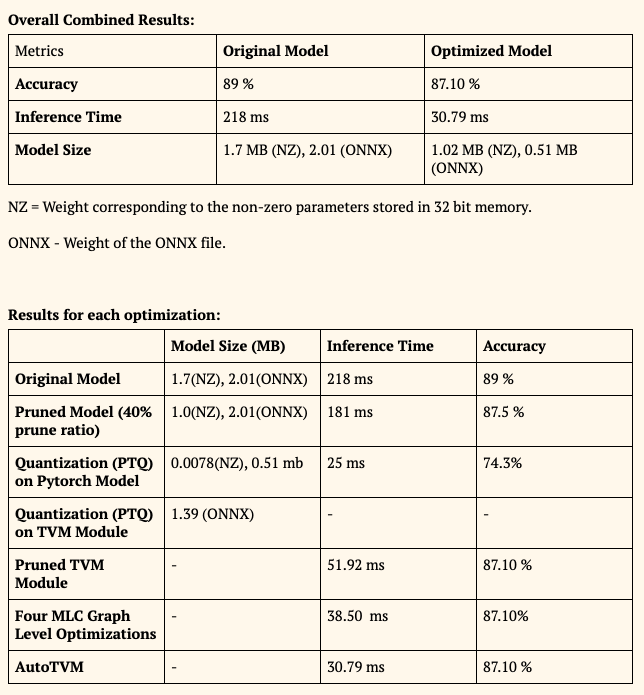

In [ ]:
!git clone https://github.com/sirius-ai/LPRNet_Pytorch.git
%cd LPRNet_Pytorch


Cloning into 'LPRNet_Pytorch'...
remote: Enumerating objects: 1071, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 1071 (delta 25), reused 22 (delta 22), pack-reused 1037 (from 1)
Receiving objects: 100% (1071/1071), 20.04 MiB | 6.09 MiB/s, done.
Resolving deltas: 100% (35/35), done.
/content/LPRNet_Pytorch


*make sure to replace the updated LPRNET_PYTORCH/data/load_data.py file with current one on colab, Updated one can be found from the github link in the report.

In [ ]:
from model.LPRNet import LPRNet
from data.load_data import LPRDataLoader
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune

from data.load_data import CHARS, CHARS_DICT, LPRDataLoader
from PIL import Image, ImageDraw, ImageFont
from model.LPRNet import build_lprnet
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import *
from torch import optim
import torch.nn as nn
import numpy as np
import argparse
import torch
import time
import cv2
import os
import time
import os
import numpy as np
from sklearn.cluster import KMeans
import subprocess
import re
import matplotlib.pyplot as plt

## Data Loading and Initializing Modules

In [ ]:
test_dataset = LPRDataLoader(img_dir='/content/LPRNet_Pytorch/data/test',
                             imgSize=(94, 24),
                             lpr_max_len=8)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
test_dataset.__len__()

1000

In [ ]:
import torch.nn as nn
import torch

class small_basic_block(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(small_basic_block, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(ch_in, ch_out // 4, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(ch_out // 4, ch_out // 4, kernel_size=(3, 1), padding=(1, 0)),
            nn.ReLU(),
            nn.Conv2d(ch_out // 4, ch_out // 4, kernel_size=(1, 3), padding=(0, 1)),
            nn.ReLU(),
            nn.Conv2d(ch_out // 4, ch_out, kernel_size=1),
        )
    def forward(self, x):
        return self.block(x)

class LPRNet(nn.Module):
    def __init__(self, lpr_max_len, phase, class_num, dropout_rate):
        super(LPRNet, self).__init__()
        self.quant = QuantStub()
        self.dequant = DeQuantStub()
        self.phase = phase
        self.lpr_max_len = lpr_max_len
        self.class_num = class_num
        self.backbone = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1), # 0
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),  # 2
            nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 1, 1)),
            small_basic_block(ch_in=64, ch_out=128),    # *** 4 ***
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),  # 6
            nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(2, 1, 2)),
            small_basic_block(ch_in=64, ch_out=256),   # 8
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),  # 10
            small_basic_block(ch_in=256, ch_out=256),   # *** 11 ***
            nn.BatchNorm2d(num_features=256),   # 12
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(4, 1, 2)),  # 14
            nn.Dropout(dropout_rate),
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=(1, 4), stride=1),  # 16
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),  # 18
            nn.Dropout(dropout_rate),
            nn.Conv2d(in_channels=256, out_channels=class_num, kernel_size=(13, 1), stride=1), # 20
            nn.BatchNorm2d(num_features=class_num),
            nn.ReLU(),  # *** 22 ***
        )
        self.container = nn.Sequential(
            nn.Conv2d(in_channels=448+self.class_num, out_channels=self.class_num, kernel_size=(1, 1), stride=(1, 1)),
            # nn.BatchNorm2d(num_features=self.class_num),
            # nn.ReLU(),
            # nn.Conv2d(in_channels=self.class_num, out_channels=self.lpr_max_len+1, kernel_size=3, stride=2),
            # nn.ReLU(),
        )

    def forward(self, x):
        keep_features = list()
        for i, layer in enumerate(self.backbone.children()):
            if isinstance(layer, nn.MaxPool3d):
                x = x.unsqueeze(0)
                x = layer(x)
                x = x.squeeze(0)
            else:
                x = layer(x)
            if i in [2, 6, 13, 22]: # [2, 4, 8, 11, 22]
                keep_features.append(x)

        global_context = list()
        for i, f in enumerate(keep_features):
            if i in [0, 1]:
                f = nn.AvgPool2d(kernel_size=5, stride=5)(f)
            if i in [2]:
                f = nn.AvgPool2d(kernel_size=(4, 10), stride=(4, 2))(f)

            f = self.dequant(f)
            f_pow = torch.pow(f, 2)
            f_mean = torch.mean(f_pow)
            f = torch.div(f, f_mean)
            f = self.quant(f)
            global_context.append(f)

        x = torch.cat(global_context, 1)
        x = self.container(x)
        logits = torch.mean(x, dim=2)

        return logits

def build_lprnet_quantize(lpr_max_len=8, phase=False, class_num=68, dropout_rate=0.5):

    Net = LPRNet(lpr_max_len, phase, class_num, dropout_rate)

    if phase == "train":
        return Net.train()
    else:
        return Net.eval()

In [ ]:
def load_pretrained_model(checkpoint_path):
    lprnet = LPRNet(lpr_max_len=8, phase=False, class_num=68, dropout_rate=0.5)
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    lprnet.load_state_dict(checkpoint)
    lprnet.eval()
    return lprnet

CHARS = ['京', '沪', '津', '渝', '冀', '晋', '蒙', '辽', '吉', '黑',
         '苏', '浙', '皖', '闽', '赣', '鲁', '豫', '鄂', '湘', '粤',
         '桂', '琼', '川', '贵', '云', '藏', '陕', '甘', '青', '宁',
         '新',
         '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
         'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K',
         'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V',
         'W', 'X', 'Y', 'Z', 'I', 'O', '-'
         ]
def get_parser():
    class Args:
        img_size = [94, 24]
        test_img_dirs = "./data/test"
        dropout_rate = 0.5
        lpr_max_len = 8
        test_batch_size = 100
        phase_train = False
        num_workers = 8
        cuda = False
        show = False
        pretrained_model = './weights/Final_LPRNet_model.pth'
    return Args()

def collate_fn(batch):
    imgs = []
    labels = []
    lengths = []
    for _, sample in enumerate(batch):
        img, label, length = sample
        imgs.append(torch.from_numpy(img))
        labels.extend(label)
        lengths.append(length)
    labels = np.asarray(labels).flatten().astype(np.float32)

    return (torch.stack(imgs, 0), torch.from_numpy(labels), lengths)

def test(model_path):
    args = get_parser()
    args.pretrained_model = model_path

    lprnet = build_lprnet(lpr_max_len=args.lpr_max_len, phase=args.phase_train, class_num=len(CHARS), dropout_rate=args.dropout_rate)
    device = torch.device("cuda:0" if args.cuda else "cpu")
    lprnet.to(device)
    print("Successful to build network!")

    # load pretrained model
    if args.pretrained_model:
        checkpoint = torch.load(args.pretrained_model, map_location=torch.device('cpu'))
        lprnet.load_state_dict(checkpoint) # Load state dict to the model
        print("load pretrained model successful!")
    else:
        print("[Error] Can't found pretrained mode, please check!")
        return False

    test_img_dirs = os.path.expanduser(args.test_img_dirs)
    # test_dataset = LPRDataLoader(test_img_dirs.split(','), args.img_size, args.lpr_max_len)
    # try:
    Greedy_Decode_Eval(lprnet, test_dataset, args)
    # finally:
    #     # Check if window exists before attempting to destroy it
    #     if cv2.getWindowProperty('test', cv2.WND_PROP_VISIBLE) >= 1:
    #         cv2.destroyAllWindows()

def Greedy_Decode_Eval(Net, datasets, args):
    # TestNet = Net.eval()
    epoch_size = len(datasets) // args.test_batch_size
    batch_iterator = iter(DataLoader(datasets, args.test_batch_size, shuffle=True, num_workers=args.num_workers, collate_fn=collate_fn))

    Tp = 0
    Tn_1 = 0
    Tn_2 = 0
    t1 = time.time()
    for i in range(epoch_size):
        # load train data
        images, labels, lengths = next(batch_iterator)
        start = 0
        targets = []
        for length in lengths:
            label = labels[start:start+length]
            targets.append(label)
            start += length
        targets = np.array([el.numpy() for el in targets])
        imgs = images.numpy().copy()

        if args.cuda:
            images = Variable(images.cuda())
        else:
            images = Variable(images)

        # forward
        prebs = Net(images)
        # greedy decode
        prebs = prebs.cpu().detach().numpy()
        preb_labels = list()
        for i in range(prebs.shape[0]):
            preb = prebs[i, :, :]
            preb_label = list()
            for j in range(preb.shape[1]):
                preb_label.append(np.argmax(preb[:, j], axis=0))
            no_repeat_blank_label = list()
            pre_c = preb_label[0]
            if pre_c != len(CHARS) - 1:
                no_repeat_blank_label.append(pre_c)
            for c in preb_label: # dropout repeate label and blank label
                if (pre_c == c) or (c == len(CHARS) - 1):
                    if c == len(CHARS) - 1:
                        pre_c = c
                    continue
                no_repeat_blank_label.append(c)
                pre_c = c
            preb_labels.append(no_repeat_blank_label)
        for i, label in enumerate(preb_labels):
            # show image and its predict label
            if args.show:
                show(imgs[i], label, targets[i])
            if len(label) != len(targets[i]):
                Tn_1 += 1
                continue
            if (np.asarray(targets[i]) == np.asarray(label)).all():
                Tp += 1
            else:
                Tn_2 += 1
    Acc = Tp * 1.0 / (Tp + Tn_1 + Tn_2)
    print("[Info] Test Accuracy: {} [{}:{}:{}:{}]".format(Acc, Tp, Tn_1, Tn_2, (Tp+Tn_1+Tn_2)))
    t2 = time.time()
    print("[Info] Test Speed: {}s 1/{}]".format((t2 - t1) / len(datasets), len(datasets)))

def show(img, label, target):
    img = np.transpose(img, (1, 2, 0))
    img *= 128.
    img += 127.5
    img = img.astype(np.uint8)

    lb = ""
    for i in label:
        lb += CHARS[i]
    tg = ""
    for j in target.tolist():
        tg += CHARS[int(j)]

    flag = "F"
    if lb == tg:
        flag = "T"
    # img = cv2.putText(img, lb, (0,16), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.6, (0, 0, 255), 1)
    img = cv2ImgAddText(img, lb, (0, 0))
    cv2.imshow("test", img)
    print("target: ", tg, " ### {} ### ".format(flag), "predict: ", lb)
    cv2.waitKey()
    cv2.destroyAllWindows()

def cv2ImgAddText(img, text, pos, textColor=(255, 0, 0), textSize=12):
    if (isinstance(img, np.ndarray)):  # detect opencv format or not
        img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(img)
    fontText = ImageFont.truetype("data/NotoSansCJK-Regular.ttc", textSize, encoding="utf-8")
    draw.text(pos, text, textColor, font=fontText)

    return cv2.cvtColor(np.asarray(img), cv2.COLOR_RGB2BGR)



In [ ]:

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

In [ ]:
pip install onnx

In [ ]:
pip install onnxruntime

In [ ]:
import torch
import os

def export_model_to_onnx(pytorch_model):

    pytorch_model.eval()


    dummy_input = torch.randn(1, 3, 24, 94)


    output_file = "model.onnx"

    # Export the model to ONNX
    torch.onnx.export(
        pytorch_model,
        dummy_input,
        output_file,
        verbose=True,
        input_names=["input"],
        output_names=["output"],
        dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}}
    )

    # Get the size of the ONNX model
    model_size = os.path.getsize(output_file) / 1e6  # Convert bytes to MB
    print(f"Model exported to ONNX format: {output_file}")
    print(f"ONNX model size: {model_size:.2f} MB")

    return model_size


# Model Size Optimizations

## UnStructured Pruning

In [ ]:
import os
import re
import time
import subprocess
import torch
import torch.nn.utils.prune as prune
from model.LPRNet import LPRNet

def unstructured_pruning(model, prune_ratio):
    for name, module in model.named_modules():
        if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
            prune.l1_unstructured(module, name='weight', amount=prune_ratio)
    return model

def remove_pruning_params(model):
    for module in model.modules():
        if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
            prune.remove(module, 'weight')

In [ ]:
original_model = load_pretrained_model('./weights/Final_LPRNet_model.pth')

original_model_size = get_model_size(original_model, count_nonzero_only=True)/MiB


print(f"Orginal model has size={original_model_size:.4f} MiB")



Orginal model has size=1.7051 MiB


<ipython-input-62-62284a322591>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))


In [ ]:
test("./weights/Final_LPRNet_model.pth")

Successful to build network!
load pretrained model successful!


<ipython-input-62-62284a322591>:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(args.pretrained_model, map_location=torch.device('cpu'))
/usr/local

[Info] Test Accuracy: 0.896 [896:61:43:1000]
[Info] Test Speed: 0.21843782353401184s 1/1000]


In [ ]:
model = unstructured_pruning(original_model.cpu(), prune_ratio=0.4)
remove_pruning_params(model)

pruned_model_path = "/content/pruned_LPRNet_model.pth"
torch.save(model.state_dict(), pruned_model_path)

test(pruned_model_path)


pruned_model = load_pretrained_model(pruned_model_path)

# Export the model and get its size
model_size = export_model_to_onnx(pruned_model)


Successful to build network!
load pretrained model successful!


<ipython-input-62-62284a322591>:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(args.pretrained_model, map_location=torch.device('cpu'))
/usr/local

[Info] Test Accuracy: 0.875 [875:77:48:1000]
[Info] Test Speed: 0.18177327990531922s 1/1000]


<ipython-input-62-62284a322591>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))


Model exported to ONNX format: model.onnx
ONNX model size: 2.01 MB


In [ ]:
pruned_model_size = get_model_size(pruned_model, count_nonzero_only=True)/MiB


print(f"Pruned model has size={pruned_model_size:.4f} MiB")


Pruned model has size=1.0286 MiB


## Post Training Quantization on Pytorch Model

In [ ]:
import torch
import torch.nn as nn
import torch.quantization
from torch.ao.quantization import QuantStub, DeQuantStub


calibration_data = torch.randn(1, 3, 24, 94)
model = load_pretrained_model(pruned_model_path)

class QuantizedLPRNet(nn.Module):
    def __init__(self, model):
        super(QuantizedLPRNet, self).__init__()
        self.quant = QuantStub()
        self.model = model
        self.dequant = DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = self.model(x)
        x = self.dequant(x)
        return x

def load_pretrained_model(model_path):
    model = build_lprnet_quantize(lpr_max_len=8, phase=False, class_num=68, dropout_rate=0.5)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    return model

def apply_quantization(model, calibration_data):
    model = QuantizedLPRNet(model)
    model.qconfig = torch.quantization.get_default_qconfig('fbgemm')
    model_pre = torch.ao.quantization.prepare(model, inplace = False)
    model_pre.eval()
    with torch.no_grad():
      model_pre(calibration_data)
    model_quantized = torch.ao.quantization.convert(model_pre, inplace = False)
    return model_quantized

quantized_model = apply_quantization(model, calibration_data)
torch.save(quantized_model.state_dict(), 'Quantized_LPRNet_model.pth')

print("Quantization model saved!!")


<ipython-input-62-62284a322591>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
/usr/local/lib/py

Quantization model saved!!


In [ ]:
import torch.nn as nn
import torch

class small_basic_block(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(small_basic_block, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(ch_in, ch_out // 4, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(ch_out // 4, ch_out // 4, kernel_size=(3, 1), padding=(1, 0)),
            nn.ReLU(),
            nn.Conv2d(ch_out // 4, ch_out // 4, kernel_size=(1, 3), padding=(0, 1)),
            nn.ReLU(),
            nn.Conv2d(ch_out // 4, ch_out, kernel_size=1),
        )
    def forward(self, x):
        return self.block(x)

class LPRNet(nn.Module):
    def __init__(self, lpr_max_len, phase, class_num, dropout_rate):
        super(LPRNet, self).__init__()
        self.quant = QuantStub()
        self.dequant = DeQuantStub()
        self.phase = phase
        self.lpr_max_len = lpr_max_len
        self.class_num = class_num
        self.backbone = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1), # 0
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),  # 2
            nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 1, 1)),
            small_basic_block(ch_in=64, ch_out=128),    # *** 4 ***
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),  # 6
            nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(2, 1, 2)),
            small_basic_block(ch_in=64, ch_out=256),   # 8
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),  # 10
            small_basic_block(ch_in=256, ch_out=256),   # *** 11 ***
            nn.BatchNorm2d(num_features=256),   # 12
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(4, 1, 2)),  # 14
            nn.Dropout(dropout_rate),
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=(1, 4), stride=1),  # 16
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),  # 18
            nn.Dropout(dropout_rate),
            nn.Conv2d(in_channels=256, out_channels=class_num, kernel_size=(13, 1), stride=1), # 20
            nn.BatchNorm2d(num_features=class_num),
            nn.ReLU(),  # *** 22 ***
        )
        self.container = nn.Sequential(
            nn.Conv2d(in_channels=448+self.class_num, out_channels=self.class_num, kernel_size=(1, 1), stride=(1, 1)),
            # nn.BatchNorm2d(num_features=self.class_num),
            # nn.ReLU(),
            # nn.Conv2d(in_channels=self.class_num, out_channels=self.lpr_max_len+1, kernel_size=3, stride=2),
            # nn.ReLU(),
        )

    def forward(self, x):
        keep_features = list()
        for i, layer in enumerate(self.backbone.children()):
            if isinstance(layer, nn.MaxPool3d):
                x = x.unsqueeze(0)
                x = layer(x)
                x = x.squeeze(0)
            else:
                x = layer(x)
            if i in [2, 6, 13, 22]: # [2, 4, 8, 11, 22]
                keep_features.append(x)

        global_context = list()
        for i, f in enumerate(keep_features):
            if i in [0, 1]:
                f = nn.AvgPool2d(kernel_size=5, stride=5)(f)
            if i in [2]:
                f = nn.AvgPool2d(kernel_size=(4, 10), stride=(4, 2))(f)

            f = self.dequant(f)
            f_pow = torch.pow(f, 2)
            f_mean = torch.mean(f_pow)
            f = torch.div(f, f_mean)
            f = self.quant(f)
            global_context.append(f)

        x = torch.cat(global_context, 1)
        x = self.container(x)
        logits = torch.mean(x, dim=2)

        return logits

def build_lprnet_quantize(lpr_max_len=8, phase=False, class_num=68, dropout_rate=0.5):

    Net = LPRNet(lpr_max_len, phase, class_num, dropout_rate)

    if phase == "train":
        return Net.train()
    else:
        return Net.eval()

In [ ]:
import time
import cv2
import os
import time
from data.load_data import CHARS, CHARS_DICT, LPRDataLoader
from PIL import Image, ImageDraw, ImageFont
from torch import optim
import torch.nn as nn
import numpy as np
import argparse
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import *

def collate_fn(batch):
    imgs = []
    labels = []
    lengths = []
    for _, sample in enumerate(batch):
        img, label, length = sample
        imgs.append(torch.from_numpy(img))
        labels.extend(label)
        lengths.append(length)
    labels = np.asarray(labels).flatten().astype(np.float32)

    return (torch.stack(imgs, 0), torch.from_numpy(labels), lengths)


datasets = test_dataset
epoch_size = len(datasets) // 100
batch_iterator = iter(DataLoader(datasets, 100, shuffle=True, num_workers=8, collate_fn=collate_fn))


model_path = pruned_model_path
pruned_model = load_pretrained_model(model_path)
calibration_data,_,_ = next(iter(DataLoader(datasets,100, shuffle = True, collate_fn = collate_fn)))
quantized_model = apply_quantization(pruned_model, calibration_data)


Tp = 0
Tn_1 = 0
Tn_2 = 0
t1 = time.time()
for i in range(epoch_size):
    # load train data
    images, labels, lengths = next(batch_iterator)
    start = 0
    targets = []
    for length in lengths:
        label = labels[start:start+length]
        targets.append(label)
        start += length
    targets = np.array([el.numpy() for el in targets])
    imgs = images.numpy().copy()


    images = Variable(images)

    prebs = quantized_model(images)
    # greedy decode
    prebs = prebs.cpu().detach().numpy()
    preb_labels = list()
    for i in range(prebs.shape[0]):
        preb = prebs[i, :, :]
        preb_label = list()
        for j in range(preb.shape[1]):
            preb_label.append(np.argmax(preb[:, j], axis=0))
        no_repeat_blank_label = list()
        pre_c = preb_label[0]
        if pre_c != len(CHARS) - 1:
            no_repeat_blank_label.append(pre_c)
        for c in preb_label: # dropout repeate label and blank label
            if (pre_c == c) or (c == len(CHARS) - 1):
                if c == len(CHARS) - 1:
                    pre_c = c
                continue
            no_repeat_blank_label.append(c)
            pre_c = c
        preb_labels.append(no_repeat_blank_label)
    for i, label in enumerate(preb_labels):
        if len(label) != len(targets[i]):
            Tn_1 += 1
            continue
        if (np.asarray(targets[i]) == np.asarray(label)).all():
            Tp += 1
        else:
            Tn_2 += 1
Acc = Tp * 1.0 / (Tp + Tn_1 + Tn_2)
print("[Info] Test Accuracy: {} [{}:{}:{}:{}]".format(Acc, Tp, Tn_1, Tn_2, (Tp+Tn_1+Tn_2)))
t2 = time.time()
print("[Info] Test Speed: {}s 1/{}]".format((t2 - t1) / len(datasets), len(datasets)))

<ipython-input-72-a447caf86665>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))


[Info] Test Accuracy: 0.743 [743:149:108:1000]
[Info] Test Speed: 0.025474725008010863s 1/1000]


In [ ]:
quantized_model_size = get_model_size(quantized_model, count_nonzero_only=True)/MiB


print(f"Quantized model has size={quantized_model_size:.4f} MiB")


Quantized model has size=0.0078 MiB


In [ ]:

quantized_model_size = export_model_to_onnx(quantized_model)


print(f"Quantized model has size from onnx={quantized_model_size:.4f} MiB")


UnsupportedOperatorError: Exporting the operator 'quantized::batch_norm2d' to ONNX opset version 17 is not supported. Please feel free to request support or submit a pull request on PyTorch GitHub: https://github.com/pytorch/pytorch/issues.

In [ ]:
size_mb = os.path.getsize(model_path) / (1024 * 1024)
print(f"Original Model Size: {size_mb:.2f} MB")

Original Model Size: 1.73 MB


In [ ]:
size_mb = os.path.getsize("Quantized_LPRNet_model.pth") / (1024 * 1024)
print(f"Quantized Model Size: {size_mb:.2f} MB")

Quantized Model Size: 0.51 MB


# MLC Optimizations

## Graph level Optimizations



1.   SimplifyInference
2.   FoldConstant
3.   FuseOps (fuse_opt_level=3)
4.   AlterOpLayout





In [ ]:
# Create a dummy input tensor matching the input shape of your model
dummy_input = torch.randn(1, 3, 24, 94)  # Example input size

# Dequantize the quantized model
# dequantized_model = dequantize_model(quantized_model)

# Convert to TorchScript
scripted_model = torch.jit.trace(pruned_model, dummy_input)

In [ ]:
!python3 -m  pip install mlc-ai-cpu -f https://mlc.ai/wheels

Looking in links: https://mlc.ai/wheels
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.8/185.8 MB 5.5 MB/s eta 0:00:00


In [ ]:
import tvm
from tvm import relay
import numpy as np
from tvm.contrib import graph_executor

# Define input shape and data type
input_name = "input0"
target =  "llvm"
input_shapes = [(input_name, (1, 3, 24, 94))]

# Import the TorchScript model into TVM
mod, params = relay.frontend.from_pytorch(scripted_model, input_shapes)



# Compile the model
with tvm.transform.PassContext(opt_level=3):
    lib = relay.build(mod, target=target, params=params)


# Create a TVM runtime module
dev = tvm.cpu()
module = graph_executor.GraphModule(lib["default"](dev))

# Set input data
input_data = np.random.randn(1, 3, 24, 94).astype("float32")
input_img, in_name, label_len  = test_dataset.__getitem__(0)


# Run inference
module.run()

# Get the output
output = module.get_output(0).asnumpy()


# Measure inference time
evaluator = module.module.time_evaluator("run", dev, number=100, repeat=10)
time_results = evaluator()
mean_inference_time = time_results.mean
print(f"Inference Time: {mean_inference_time * 1e3:.2f} ms")


Inference Time: 51.92 ms


In [ ]:
from tvm import relay, transform

# Apply graph-level optimization
seq = transform.Sequential(
    [
        relay.transform.SimplifyInference(),  # Simplify inference graph
        relay.transform.FoldConstant(),       # Fold constants
        relay.transform.FuseOps(fuse_opt_level=3),  # Fuse operators
        relay.transform.AlterOpLayout(),      # Alter data layout for optimization
    ]
)

# Apply optimizations to the Relay module
with tvm.transform.PassContext(opt_level=3):
    mod = seq(mod)


# Compile the optimized module
with tvm.transform.PassContext(opt_level=3):
    lib = relay.build(mod, target=target, params=params)


In [ ]:
import numpy as np
from tvm.contrib import graph_executor

# Create a runtime module
dev = tvm.cpu()
module = graph_executor.GraphModule(lib["default"](dev))

# Set input data
input_data = np.random.randn(1, 3, 24, 94).astype("float32")
module.set_input("input0", tvm.nd.array(input_data))

# Warm up the model to ensure cache optimization
module.run()

# Measure inference time
evaluator = module.module.time_evaluator("run", dev, number=100, repeat=10)
time_results = evaluator()
mean_inference_time = time_results.mean  # Average inference time in seconds
print(f"Inference Time: {mean_inference_time * 1e3:.2f} ms")


Inference Time: 38.50 ms


In [ ]:
def evaluate_tvm_model(lib, test_dataset, char_map):
    # Create a runtime module
    dev = tvm.cpu()
    module = graph_executor.GraphModule(lib["default"](dev))

    total_samples = 0
    correct_predictions = 0

    for image, label, size in test_dataset:
        input_data = image.astype("float32").reshape(1, 3, 24, 94)
        ground_truth = label[:size]

        # Set input and run inference
        module.set_input("input0", tvm.nd.array(input_data))
        module.run()

        # Get output and decode
        output_data = module.get_output(0).asnumpy()
        decoded_output = decode_output(output_data, char_map)
        expected_output = decode_ground_truth(ground_truth, char_map)

        # Print debug information
        print(f"Expected: {expected_output}, Predicted: {decoded_output}")

        # Compare outputs
        if decoded_output == expected_output:
            correct_predictions += 1

        total_samples += 1

    # Calculate accuracy
    accuracy = correct_predictions / total_samples
    print(f"Accuracy: {accuracy * 100:.2f}%")

# Decoding function for model output
def decode_output(output_data, char_map):
    preb_label = []
    preb = output_data[0, :, :]
    for j in range(preb.shape[1]):
        preb_label.append(np.argmax(preb[:, j], axis=0))

    no_repeat_blank_label = []
    pre_c = preb_label[0]
    if pre_c != len(char_map) - 1:
        no_repeat_blank_label.append(pre_c)

    for c in preb_label:
        if (pre_c == c) or (c == len(char_map) - 1):
            pre_c = c
            continue
        no_repeat_blank_label.append(c)
        pre_c = c

    return "".join([char_map[int(x)] for x in no_repeat_blank_label])

# Ground truth decoding function
def decode_ground_truth(ground_truth, char_map):
    return "".join([char_map[int(x)] for x in ground_truth])


In [ ]:
evaluate_tvm_model(lib, test_dataset, CHARS)

Expected: 皖ASS990, Predicted: 皖ASS5990
Expected: 皖AH0V90, Predicted: 皖AH0V90
Expected: 皖AM526Y, Predicted: 皖AM526Y
Expected: 皖AC1014, Predicted: 皖AC1014
Expected: 皖A5S422, Predicted: 皖A5542
Expected: 皖AM190J, Predicted: 皖AM190J
Expected: 皖AK2A68, Predicted: 皖AK2A68
Expected: 皖AME066, Predicted: 皖AME066
Expected: 皖D93138, Predicted: 皖D930138
Expected: 皖AS6W73, Predicted: 皖AS6W73
Expected: 皖AW657T, Predicted: 皖AW657T
Expected: 浙J2K181, Predicted: 浙J2K181
Expected: 皖A9U522, Predicted: 皖A9U5229
Expected: 皖AD1B19, Predicted: 皖AD1B19
Expected: 皖AF3L16, Predicted: 皖AF3L16
Expected: 皖AWU124, Predicted: 皖AWU124
Expected: 皖A62R17, Predicted: 皖A62R17
Expected: 皖AL820L, Predicted: 皖AL820L
Expected: 皖A32C32, Predicted: 皖A32C32
Expected: 浙D911SY, Predicted: 浙D91186Y
Expected: 皖N8E309, Predicted: 皖N8E309
Expected: 皖AH6X77, Predicted: 皖AH6X77
Expected: 皖AR578L, Predicted: 皖AR578L
Expected: 皖AY532X, Predicted: 皖AY532X
Expected: 皖ACA352, Predicted: 皖ACA352
Expected: 皖AD9G33, Predicted: 皖AD9G33
Expected:

## 5. AutoTVM

In [ ]:
import tvm
from tvm import relay, autotvm
import numpy as np
from tvm.contrib import graph_executor


target = "llvm"
input_data = np.random.randn(1, 3, 24, 94).astype("float32")


# Extract tasks for tuning
tasks = autotvm.task.extract_from_program(
    mod["main"], target=target, params=params
)

print("Extracted tasks:")
for task in tasks:
    print(task)

# 2. Define tuning options
from tvm.autotvm.tuner import XGBTuner

tuning_options = {
    "log_filename": "tuning.log",
    "number": 100,
    "early_stopping": 500,
    "measure_option": autotvm.measure_option(
        builder=autotvm.LocalBuilder(),  # Build locally
        runner=autotvm.LocalRunner(     # Run locally
            timeout=10, repeat=3, min_repeat_ms=100, enable_cpu_cache_flush=True
        ),
    ),
}

# 3. Tune tasks
for task in tasks:
    print(f"Tuning Task: {task.name}")
    tuner = XGBTuner(task)

    # Run the tuner
    tuner.tune(
        n_trial=tuning_options["number"],
        early_stopping=tuning_options["early_stopping"],
        measure_option=tuning_options["measure_option"],
        callbacks=[
            autotvm.callback.log_to_file(tuning_options["log_filename"]),
            autotvm.callback.progress_bar(tuning_options["number"]),
        ],
    )

# 4. Apply the best tuning results
with autotvm.apply_history_best(tuning_options["log_filename"]):
    with tvm.transform.PassContext(opt_level=3):
        lib = relay.build(mod, target=target, params=params)

# 5. Run the optimized model
dev = tvm.cpu()
module = graph_executor.GraphModule(lib["default"](dev))

# Set input and run
module.set_input("input0", tvm.nd.array(input_data))
module.run()

# Measure inference time
evaluator = module.module.time_evaluator("run", dev, number=100, repeat=10)
time_results = evaluator()
print(f"Optimized Inference Time: {time_results.mean * 1e3:.2f} ms")

# 6. Save the optimized model
lib.export_library("optimized_model.so")
with open("optimized_model.json", "w") as f:
    f.write(lib.get_graph_json())


Extracted tasks:
Task(func_name=conv2d_NCHWc.x86, args=(('TENSOR', (1, 3, 24, 94), 'float32'), ('TENSOR', (64, 3, 3, 3), 'float32'), (1, 1), (0, 0, 0, 0), (1, 1), 'NCHW', 'NCHW', 'float32'), kwargs={}, workload=('conv2d_NCHWc.x86', ('TENSOR', (1, 3, 24, 94), 'float32'), ('TENSOR', (64, 3, 3, 3), 'float32'), (1, 1), (0, 0, 0, 0), (1, 1), 'NCHW', 'NCHW', 'float32'))
Task(func_name=conv2d_NCHWc.x86, args=(('TENSOR', (1, 64, 20, 90), 'float32'), ('TENSOR', (32, 64, 1, 1), 'float32'), (1, 1), (0, 0, 0, 0), (1, 1), 'NCHW', 'NCHW', 'float32'), kwargs={}, workload=('conv2d_NCHWc.x86', ('TENSOR', (1, 64, 20, 90), 'float32'), ('TENSOR', (32, 64, 1, 1), 'float32'), (1, 1), (0, 0, 0, 0), (1, 1), 'NCHW', 'NCHW', 'float32'))
Task(func_name=conv2d_NCHWc.x86, args=(('TENSOR', (1, 32, 20, 90), 'float32'), ('TENSOR', (32, 32, 3, 1), 'float32'), (1, 1), (1, 0, 1, 0), (1, 1), 'NCHW', 'NCHW', 'float32'), kwargs={}, workload=('conv2d_NCHWc.x86', ('TENSOR', (1, 32, 20, 90), 'float32'), ('TENSOR', (32, 32, 3,

In [ ]:
evaluate_tvm_model(lib, test_dataset, CHARS)

Expected: 皖ASS990, Predicted: 皖ASS5990
Expected: 皖AH0V90, Predicted: 皖AH0V90
Expected: 皖AM526Y, Predicted: 皖AM526Y
Expected: 皖AC1014, Predicted: 皖AC1014
Expected: 皖A5S422, Predicted: 皖A5542
Expected: 皖AM190J, Predicted: 皖AM190J
Expected: 皖AK2A68, Predicted: 皖AK2A68
Expected: 皖AME066, Predicted: 皖AME066
Expected: 皖D93138, Predicted: 皖D930138
Expected: 皖AS6W73, Predicted: 皖AS6W73
Expected: 皖AW657T, Predicted: 皖AW657T
Expected: 浙J2K181, Predicted: 浙J2K181
Expected: 皖A9U522, Predicted: 皖A9U5229
Expected: 皖AD1B19, Predicted: 皖AD1B19
Expected: 皖AF3L16, Predicted: 皖AF3L16
Expected: 皖AWU124, Predicted: 皖AWU124
Expected: 皖A62R17, Predicted: 皖A62R17
Expected: 皖AL820L, Predicted: 皖AL820L
Expected: 皖A32C32, Predicted: 皖A32C32
Expected: 浙D911SY, Predicted: 浙D91186Y
Expected: 皖N8E309, Predicted: 皖N8E309
Expected: 皖AH6X77, Predicted: 皖AH6X77
Expected: 皖AR578L, Predicted: 皖AR578L
Expected: 皖AY532X, Predicted: 皖AY532X
Expected: 皖ACA352, Predicted: 皖ACA352
Expected: 皖AD9G33, Predicted: 皖AD9G33
Expected:

## Post Training Quantization on TVM Graph Module

In [ ]:
pip install onnx

In [ ]:
pip install onnxruntime

In [ ]:
class CalibrationDataset:
    def __init__(self, real_dataset):
        self.real_dataset = real_dataset

    def __iter__(self):
        for image, _, _ in self.real_dataset:  # Use images from the dataset
            yield {"input0": image.astype("float32").reshape(1, 3, 24, 94)}

# Use real test dataset as calibration dataset
calibration_dataset = CalibrationDataset(test_dataset)


In [ ]:
# Save the original model
lib.export_library("original_model.so")
with open("original_model.json", "w") as f:
    f.write(lib.get_graph_json())

# Measure original model size
original_size = os.path.getsize("original_model.so") + os.path.getsize("original_model.json")
print(f"Original Model Size: {original_size / 1e6:.2f} MB")

Original Model Size: 2.73 MB


In [ ]:
from tvm.relay.quantize import qconfig, quantize
import torch
import tvm
from tvm import relay
import numpy as np
import onnx
import onnxruntime as ort
from tvm.contrib import graph_executor
import os


input_name = "input0"
input_shapes = [(input_name, (1, 3, 24, 94))]

# Import the TorchScript model into TVM
mod, params = relay.frontend.from_pytorch(scripted_model, input_shapes)
# Quantize the model
calibration_dataset = CalibrationDataset(test_dataset)


# Quantization configuration
with qconfig(
    nbit_input=8 ,  # Use 8-bit for inputs
    nbit_weight=8,  # Use 8-bit for weights
    nbit_activation=32,  # Keep activations in higher precision
    calibrate_mode="global_scale",  # Use global scale for calibration
    global_scale=4.0,  # Smaller scale reduces quantization impact
    weight_scale="max",  # Use max scaling for weights
    skip_dense_layer=True,  # Skip all dense layers
    skip_conv_layers=[0],  # Skip the first convolutional layer
    do_simulation=False,  # Use float simulation (no actual quantization)
):
    with tvm.transform.PassContext(opt_level=3):
        quantized_mod = quantize(mod, params=params, dataset=calibration_dataset)


# Compile quantized model
quantized_lib = relay.build(quantized_mod, target="llvm", params=params)
# Save the quantized model
quantized_lib.export_library("quantized_model.so")
with open("quantized_model.json", "w") as f:
    f.write(quantized_lib.get_graph_json())

# Measure model size
quantized_size = os.path.getsize("quantized_model.so") + os.path.getsize("quantized_model.json")
print(f"Quantized Model Size: {quantized_size / 1e6:.2f} MB")



Quantized Model Size: 1.39 MB


In [ ]:
# evaluate_tvm_model(quantized_lib, test_dataset, CHARS)

Size reduced from 2.73 mb to 1.39 mb but accuracy dropped very much so not considering this approach.

#Summary
Full detailed summary can be found in the report, below are the final results:

Model Size Reduction Optimizations:
1.   Pruning (Unstructured)
2.   Post Training Quantization on Pytorch Model
3.   Post Training Quantization on TVM Graph Module


MLC Optimizations:
1.   SimplifyInference (TVM Graph Level Optimization )
2.   FoldConstant
3.   FuseOps (fuse_opt_level=3)
4.   AlterOpLayout
5.   AutoTVM


Results:

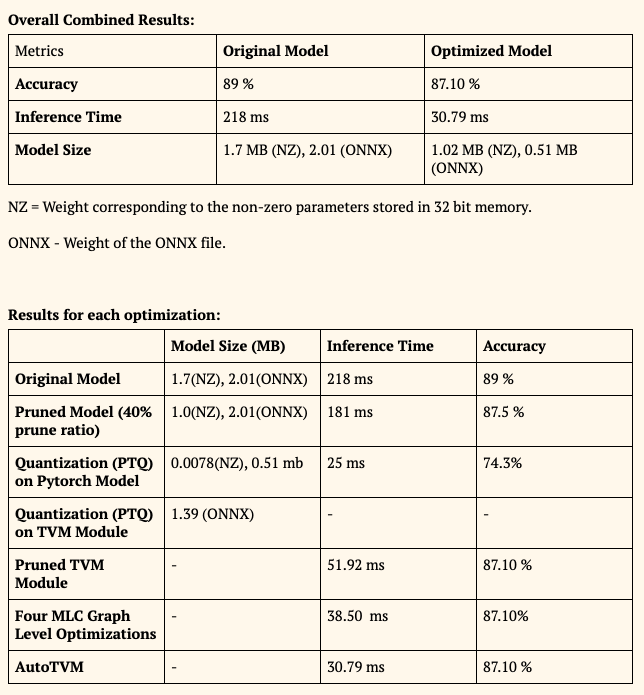